# General nuclear segmentation training notebook

This notebook trains a model to perform nuclear segmentation of fluorescent microscopy images.

## Part 1: Import relevant python packages

This section imports python packages that are used throughout the notebook and defines parameters that can be used with papermill

In [1]:
import os
import errno

import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import deepcell

In [2]:
# Define parameters that can be set with papermill
backbone = 'resnet50'
dataset_name='general_nuclear'
n_epochs = 8
date = '04242020'
dataset_fraction = .01
train_test_seed = 0
train_permutation_seed = 0
train_val_seed=314
model_type = 'watershed'
batch_size = 4 if model_type == 'retinamask' else 16

In [3]:
# Parameters
n_epochs = 16
batch_size = 16
date = "04262020"
filename = "nuclear_0_0.5_mobilenetv2_pixelwise"
train_permutation_seed = 0
dataset_fraction = 0.5
backbone = "mobilenetv2"
model_type = "pixelwise"


## Part 2: Load training data and create data generators

Data generators augment data and feed it into the model training process. Here, we define the generators that will be used to train our segmentation model.

In [4]:
from deepcell.utils.data_utils import get_data, reshape_movie
from deepcell import image_generators
from deepcell.utils import train_utils
from sklearn.model_selection import train_test_split
from deepcell_tracking.utils import load_trks

# Helper function - get unique tracks
def get_n_tracks(array):
    # array with dims (batch, time, x, y, c)
    n_tracks = 0
    for b in array:
        n_tracks += len(np.unique(b)) - 1
    return n_tracks

# Helper function - get unique cells
def get_n_cells(array):
    # array with dims (batch, time, x, y, c)
    n_cells = 0
    for b in array:
        for t in b:
            n_cells += len(np.unique(t)) - 1
    return n_cells

# Helper function - convert indices
def convert_indices(indices, X_list):
    N_batches = np.array([x.shape[0] for x in X_list])
    N_cumsum = np.cumsum(N_batches)
    converted_index = []
    for i in range(len(X_list)):
        if i==0:
            i_index = indices[indices < N_cumsum[i]]
            converted_index.append(i_index)
        else:
            i_index = indices[np.logical_and(indices < N_cumsum[i], indices >= N_cumsum[i-1])] - N_cumsum[i-1]
            converted_index.append(i_index)    
    return converted_index

# Helper function - reshape movies
def reshape_list_of_movies(X_list, y_list, reshape_size=128, crop=False):
    X_reshape = []
    y_reshape = []
    for Xl, yl in zip(X_list, y_list):
        Xr, yr = reshape_movie(Xl, yl, reshape_size=reshape_size)
        Xr = Xr.reshape((-1, reshape_size, reshape_size, Xr.shape[-1]))
        yr = yr.reshape((-1, reshape_size, reshape_size, yr.shape[-1]))
        X_reshape.append(Xr)
        y_reshape.append(yr)
    X_reshape = np.concatenate(X_reshape, axis=0)
    y_reshape = np.concatenate(y_reshape, axis=0)
    
    return X_reshape, y_reshape

# Load datasets 
dataset_direc = '/data/training_data/'

hela_filename = 'HeLa_S3.trks'
hek_filename = 'HEK293.trks'
nih_filename = '3T3_NIH.trks'
raw_filename = 'RAW2647.trks'

filenames = [hela_filename, hek_filename, nih_filename, raw_filename]

X_train = []
y_train = []

X_test = []
y_test = []

for filename in filenames:
    path = os.path.join(dataset_direc, filename)
    training_data = load_trks(path)
    X = training_data['X']
    y = training_data['y']
    
    print(X.shape, y.shape)
    
    # Split into training and testing dataset
    Xt, Xtest, yt, ytest = train_test_split(X, y, test_size=0.2, random_state=train_test_seed)
    
    # Crop test dataset
    X_test = [arr[:,:,0:128,0:128,:] for arr in X_test]
    y_test = [arr[:,:,0:128,0:128,:] for arr in y_test]
    
    X_train.append(Xt)
    y_train.append(yt)
    X_test.append(Xtest)
    y_test.append(ytest)
    
# Select subset of the training data
N_batches = sum([x.shape[0] for x in X_train])
index = np.arange(N_batches)
dataset_size = int(dataset_fraction * N_batches)
permuted_index = np.random.RandomState(seed=train_permutation_seed).permutation(index)
reduced_index = permuted_index[0:dataset_size]
converted_index = convert_indices(reduced_index, X_train)

X_reduced = [x[ci] for x, ci in zip(X_train, converted_index)]
y_reduced = [y[ci] for y, ci in zip(y_train, converted_index)]

# Split into training and validation datasets
N_batches = sum([x.shape[0] for x in X_reduced])
index = np.arange(N_batches)
val_size = int(0.2 * N_batches)
permuted_index = np.random.RandomState(seed=train_val_seed).permutation(index)
val_index = permuted_index[0:val_size]
train_index = permuted_index[val_size:]

val_ci = convert_indices(val_index, X_reduced)
train_ci = convert_indices(train_index, X_reduced)

X_train = [x[ci] for x, ci in zip(X_reduced, train_ci)]
y_train = [y[ci] for y, ci in zip(y_reduced, train_ci)]

X_val = [x[ci] for x, ci in zip(X_reduced, val_ci)]
y_val = [y[ci] for y, ci in zip(y_reduced, val_ci)]
    
# Record the number of tracks and cells
n_tracks_train = sum([get_n_tracks(y) for y in y_train])
n_tracks_val = sum([get_n_tracks(y) for y in y_val])
n_tracks_test = sum([get_n_tracks(y) for y in y_test])

n_cells_train = sum([get_n_cells(y) for y in y_train])
n_cells_val = sum([get_n_cells(y) for y in y_val])
n_cells_test = sum([get_n_cells(y) for y in y_test])
    
# Reshape the datasets
X_train, y_train = reshape_list_of_movies(X_train, y_train)
X_val, y_val = reshape_list_of_movies(X_val, y_val)
X_test, y_test = reshape_list_of_movies(X_test, y_test)

train_dict = {'X':X_train, 'y':y_train}
val_dict = {'X':X_val, 'y':y_val}
test_dict = {'X':X_test, 'y':y_test}

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print('Number of training tracks {}'.format(n_tracks_train))
print('Number of validation tracks {}'.format(n_tracks_val))
print('Number of testing tracks {}'.format(n_tracks_test))

print('Number of training cells {}'.format(n_cells_train))
print('Number of validation cells {}'.format(n_cells_val))
print('Number of testing cells {}'.format(n_cells_test))

(180, 40, 216, 256, 1) (180, 40, 216, 256, 1)
(259, 30, 135, 160, 1) (259, 30, 135, 160, 1)
(240, 30, 154, 182, 1) (240, 30, 154, 182, 1)
(124, 30, 202, 240, 1) (124, 30, 202, 240, 1)
Reshaped feature data from (51, 40, 216, 256, 1) to (204, 40, 128, 128, 1)
Reshaped training data from (51, 40, 216, 256, 1) to (204, 40, 128, 128, 1)
Reshaped feature data from (85, 30, 135, 160, 1) to (340, 30, 128, 128, 1)
Reshaped training data from (85, 30, 135, 160, 1) to (340, 30, 128, 128, 1)
Reshaped feature data from (82, 30, 154, 182, 1) to (328, 30, 128, 128, 1)
Reshaped training data from (82, 30, 154, 182, 1) to (328, 30, 128, 128, 1)
Reshaped feature data from (39, 30, 202, 240, 1) to (156, 30, 128, 128, 1)
Reshaped training data from (39, 30, 202, 240, 1) to (156, 30, 128, 128, 1)
Reshaped feature data from (20, 40, 216, 256, 1) to (80, 40, 128, 128, 1)
Reshaped training data from (20, 40, 216, 256, 1) to (80, 40, 128, 128, 1)
Reshaped feature data from (16, 30, 135, 160, 1) to (64, 30, 12

In [5]:
from deepcell.utils.retinanet_anchor_utils import generate_anchor_params
from tensorflow.python.keras import backend as K

# Get anchor settings for RetinaMask models
pyramid_levels = ['P3', 'P4']
anchor_size_dict = {'P3':16, 'P4':32}
anchor_params = generate_anchor_params(pyramid_levels, anchor_size_dict)

# Data augmentation parameters
generator_kwargs = {}
generator_kwargs['rotation_range'] = 180
generator_kwargs['shear_range'] = 0
generator_kwargs['zoom_range'] = 0.25
generator_kwargs['horizontal_flip'] = True
generator_kwargs['vertical_flip'] = True

generator_val_kwargs = {}
generator_val_kwargs['rotation_range'] = 0
generator_val_kwargs['shear_range'] = 0
generator_val_kwargs['zoom_range'] = 0
generator_val_kwargs['horizontal_flip'] = False
generator_val_kwargs['vertical_flip'] = False

# Minimum number of objects in an image
min_objects = 3 if model_type == 'retinamask' else 0

# Random seed
seed=808

if model_type == 'watershed':
    datagen = image_generators.SemanticDataGenerator(**generator_kwargs)
    datagen_val = image_generators.SemanticDataGenerator(**generator_val_kwargs)
    
    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=['centroid', 'watershed-cont', 'fgbg'],
        transforms_kwargs={'watershed-cont': {'erosion_width': 0}, 'centroid': {'alpha':'auto', 'beta':0.5}},
        min_objects=min_objects,
        batch_size=batch_size)

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=['centroid', 'watershed-cont', 'fgbg'],
        transforms_kwargs={'watershed-cont': {'erosion_width': 0}, 'centroid': {'alpha':'auto', 'beta':0.5}},
        min_objects=min_objects,
        batch_size=batch_size)
    
elif model_type == 'pixelwise':
    datagen = image_generators.SemanticDataGenerator(**generator_kwargs)
    datagen_val = image_generators.SemanticDataGenerator(**generator_val_kwargs)
    
    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=['pixelwise'],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size)

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=['pixelwise'],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size)

elif model_type == 'retinamask':
    datagen = image_generators.RetinaNetGenerator(**generator_kwargs)
    datagen_val = image_generators.RetinaNetGenerator(**generator_val_kwargs)
    
    train_data = datagen.flow(
        train_dict=train_dict,
        seed=seed,
        transforms=[],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size,
        anchor_params=anchor_params,
        pyramid_levels=pyramid_levels,
        include_masks=True)
    
    val_data = datagen_val.flow(
        train_dict=val_dict,
        seed=seed,
        transforms=[],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size,
        anchor_params=anchor_params,
        pyramid_levels=pyramid_levels,
        include_masks=True)
    

## Part 3: Define model

Here we define a PanopticNet to perform the image segmentation. This model will predict the inner distance and outer distance transform (as done in ), as well as the foreground-background transform.

In [6]:
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell.model_zoo.retinamask import RetinaMask
from deepcell import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.losses import MSE

# Define optimizer
optimizer = Adam(lr=1e-4, clipnorm=0.001)
    
if model_type == 'watershed':
    model = PanopticNet(backbone,
                       input_shape=train_data.x.shape[1:],
                       norm_method='whole_image',
                       num_semantic_heads=3,
                       num_semantic_classes=[1,1,2],
                       location=True,
                       include_top=True,
                       interpolation='bilinear',
                       lite=True)

    # Define loss
    loss_layers = ['semantic_0', 'semantic_1', 'semantic_2']
    loss = {}

    for layer_name in loss_layers:
        n_classes = model.get_layer(layer_name).output_shape[-1]
        if n_classes > 1:
            def loss_function(y_true, y_pred):
                return 0.01 * losses.weighted_categorical_crossentropy(
                    y_true, y_pred, n_classes=n_classes)
            loss[layer_name] = loss_function
        elif n_classes == 1:
            loss[layer_name] = MSE

    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    
elif model_type == 'pixelwise':
    model = PanopticNet(backbone,
                       input_shape=train_data.x.shape[1:],
                       norm_method='whole_image',
                       num_semantic_heads=1,
                       num_semantic_classes=[3],
                       location=False,
                       include_top=True)

    # Define loss
    loss = {}
    
    def loss_function(y_true, y_pred):
        return losses.weighted_categorical_crossentropy(
                    y_true, y_pred, n_classes=3)
    
    loss['semantic_0'] = loss_function
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    
elif model_type == 'retinamask':
    model = RetinaMask(backbone,
                      num_classes=1,
                      input_shape=train_data.x.shape[1:],
                      norm_method='whole_image',
                      use_imagenet=True,
                      pyramid_levels=pyramid_levels,
                      anchor_params=anchor_params)
    
    # Define loss
    retinanet_losses = losses.RetinaNetLosses()
    loss = {
        'regression': retinanet_losses.regress_loss,
        'classification': retinanet_losses.classification_loss,
        'masks': retinanet_losses.mask_loss
    }
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    
model.summary()

W0427 22:32:01.454797 140520475158336 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step
Model: "panopticnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
norm (ImageNormalization2D)     (None, 128, 128, 1)  0           input_0[0][0]                    
__________________________________________________________________________________________________
conv_channels (Conv2D)          (None, 128, 128, 3)  6           norm[0][0]                       
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           conv_channels[0][0]              
_________________________

## Part 4: Define model training parameters

Here, we define all of the parameters needed for training. The model trainer objects will record these metadata after training.

In [7]:
model_name = 'nuclear_{}_{}_{}_{}'.format(str(train_permutation_seed), dataset_fraction, backbone, model_type)
model_path = os.path.join('/data', 'models', date, model_name)
dataset_metadata={'name': dataset_name,
                  'other': 'Pooled nuclear data from HEK293, HeLa-S3, NIH-3T3, and RAW264.7 cells.'}
training_kwargs = {}
training_kwargs['batch_size'] = batch_size
training_kwargs['lr'] = 1e-5 if model_type=='retinamask' else 1e-4
training_kwargs['lr_decay'] = 0.95
training_kwargs['training_seed'] = 0
training_kwargs['n_epochs'] = n_epochs
training_kwargs['training_steps_per_epoch'] = 82800//16 if model_type == 'retinamask' else 82800 // training_kwargs['batch_size']
training_kwargs['validation_steps_per_epoch'] = val_data.y.shape[0] // training_kwargs['batch_size']

## Part 5: Create the model trainer and train the model

Here, we create the model trainer, train the model, and export the model - along with the metadata and benchmarks

In [8]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import json
import hashlib
import numpy as np

from skimage.morphology import remove_small_objects

from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler, get_callbacks
from deepcell.metrics import Metrics

from tensorflow.python.compiler.tensorrt import trt_convert as trt

class ModelTrainer(object):
    def __init__(self, 
                model,
                model_name,
                model_path,
                train_generator,
                validation_generator,
                benchmarking_data=None,
                log_dir=None,
                tfserving_path=None,
                training_callbacks='default',
                max_batch_size=256,
                export_precisions = ['fp16'],
                postprocessing_fn=None,
                postprocessing_kwargs={},
                predict_batch_size=4,
                model_version=0,
                min_size=100,
                dataset_metadata={},
                training_kwargs={}):
    
        """
        Model trainer class for segmentation models. This class eases model development by
        linking relevant metadata (dataset, training parameters, benchmarking) to the model
        training process.
        """

        # Add model information
        self.model = model
        self.model_name = model_name
        self.model_path = model_path
        self.model_version = model_version

        # Add dataset information
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.benchmarking_data = benchmarking_data
        self.dataset_metadata = dataset_metadata
        self.postprocessing_fn = postprocessing_fn
        self.postprocessing_kwargs = postprocessing_kwargs
        self.predict_batch_size = predict_batch_size

        # Add benchmarking information
        self.min_size = min_size

        # Add export information
        self.max_batch_size = max_batch_size
        self.export_precisions = export_precisions

        # Add directories for logging and model export
        if log_dir is None:
            self.log_dir = os.path.join(model_path, 'logging')
        else:
            self.log_dir = log_dir
        
        if tfserving_path is None:
            self.tfserving_path = os.path.join(model_path, 'serving')
        else:
            self.tfserving_path = tfserving_path

        # Add training kwargs
        self.batch_size = training_kwargs.pop('batch_size', 1)
        self.training_steps_per_epoch = training_kwargs.pop('training_steps_per_epoch', 
                                                self.train_generator.y.shape[0] // self.batch_size)
        self.validation_steps_per_epoch = training_kwargs.pop('validation_steps_per_epoch', 
                                                self.validation_generator.y.shape[0] // self.batch_size)
        self.n_epochs = training_kwargs.pop('n_epochs', 8)
        self.lr = training_kwargs.pop('lr', 1e-5)
        self.lr_decay = training_kwargs.pop('lr_decay', 0.95)
        self.lr_sched = training_kwargs.pop('lr_sched', rate_scheduler(lr=self.lr, decay=self.lr_decay))

        # Add callbacks
        if training_callbacks == 'default':
            model_name = os.path.join(model_path, model_name + '.h5')
            self.training_callbacks = get_callbacks(model_name, lr_sched=self.lr_sched,
                                        tensorboard_log_dir=self.log_dir,
                                        save_weights_only=False,
                                        monitor='val_loss', verbose=1)
        else:
            self.training_callbacks = training_callbacks

        self.trained = False

        return None

    def _create_hash(self):
        if not self.trained:
            raise ValueError('Can only create a hash for a trained model')
        else:
            weights = []
            for layer in self.model.layers:
                weights += layer.get_weights()
            summed_weights_list = [np.sum(w) for w in weights]
            summed_weights = sum(summed_weights_list)
            model_hash = hashlib.md5(str(summed_weights).encode())
            self.model_hash = model_hash.hexdigest()

    def _fit(self):
        loss_history = self.model.fit_generator(
        self.train_generator,
        steps_per_epoch=self.training_steps_per_epoch,
        epochs=self.n_epochs,
        validation_data=self.validation_generator,
        validation_steps=self.validation_steps_per_epoch,
        callbacks=self.training_callbacks,
        verbose=2)

        self.trained = True
        self.loss_history = loss_history

        return None

    def _benchmark(self):
        if not self.trained:
            raise ValueError('Model training is not complete')
        else:
            if self.benchmarking_data is None:
                x = self.validation_generator.x.copy()
                y_true = self.validation_generator.y.copy()
            else:
                x = self.benchmarking_data['X']
                y_true = self.benchmarking_data['y']

            outputs = self.model.predict(x, batch_size=self.predict_batch_size)
            y_pred = self.postprocessing_fn(outputs, **self.postprocessing_kwargs)

            if len(y_pred.shape) == 3:
                y_pred = np.expand_dims(y_pred, axis=-1)    #TODO: This is a hack because the postprocessing fn returns
                                                            #masks with no channel dimensions. This should be fixed.
            
            benchmarks = Metrics(self.model_name, seg=False)
            benchmarks.calc_object_stats(y_true, y_pred)

            # Save benchmarks in dict
            self.benchmarks = {}
            for key in benchmarks.stats.keys():
                self.benchmarks[key] = int(benchmarks.stats[key].sum())

            for i in range(y_pred.shape[0]):
                y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=self.min_size)
                y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=self.min_size)

            benchmarks = Metrics(self.model_name + ' - Removed objects less than {} pixels'.format(self.min_size), 
                                    seg=False)
            benchmarks.calc_object_stats(y_true, y_pred)

            # Save benchmarks in dict
            self.benchmarks_remove_small_objects = {}
            for key in benchmarks.stats.keys():
                self.benchmarks_remove_small_objects[key] = int(benchmarks.stats[key].sum())

        return None

    def _create_training_metadata(self):
        training_metadata = {}
        training_metadata['batch_size'] = self.batch_size
        training_metadata['lr'] = self.lr
        training_metadata['lr_decay'] = self.lr_decay
        training_metadata['n_epochs'] = self.n_epochs
        training_metadata['training_steps_per_epoch'] = self.training_steps_per_epoch
        training_metadata['validation_steps_per_epoch'] = self.validation_steps_per_epoch

        self.training_metadata = training_metadata

        return None

    def _export_tf_serving(self):
        export_model(self.model, self.tfserving_path, model_version=self.model_version)

        # Convert model to TensorRT with float16
        if 'fp16' in self.export_precisions:
            export_model_dir = os.path.join(self.tfserving_path, str(self.model_version))
            export_model_dir_fp16 = os.path.join(self.tfserving_path + '_fp16', str(self.model_version))

            converter = trt.TrtGraphConverter(input_saved_model_dir=export_model_dir,
                                            max_batch_size=self.max_batch_size,
                                            precision_mode='fp16')
            converter.convert()
            converter.save(export_model_dir_fp16)

        return None

    def create_model(self, export_serving=False, export_lite=False):

        # Train model
        self._fit()

        # Load best performing weights
        model_name = os.path.join(self.model_path, self.model_name + '.h5')
        self.model.load_weights(model_name)

        # Create model hash
        self._create_hash()

        # Create benchmarks
        self._benchmark()

        # Create model metadata
        self._create_training_metadata()

        # Save model
        model_name = os.path.join(self.model_path, self.model_name + '_' + self.model_hash + '.h5')
        self.model.save(model_name)

        # Save loss history
        loss_name = os.path.join(self.model_path, self.model_name + '_loss_' + self.model_hash + '.npz')
        np.savez(loss_name, loss_history=self.loss_history.history)

        # Save metadata (training and dataset) and benchmarks
        metadata = {}
        metadata['model_hash'] = self.model_hash
        metadata['training_metadata'] = self.training_metadata
        metadata['dataset_metadata'] = self.dataset_metadata
        metadata['benchmarks'] = self.benchmarks
        metadata['benchmarks_remove_small_objects'] = self.benchmarks_remove_small_objects

        # TODO: Saving the benchmarking object in this way saves each individual benchmark.
        # This should be refactored to save the sums.

        metadata_name = os.path.join(self.model_path, self.model_name + '_' + self.model_hash + '.json')
        
        with open(metadata_name, 'w') as json_file:
            json.dump(metadata, json_file)

        # Export tf serving model
        if export_serving:
            self._export_tf_serving()

        return None

In [9]:
from deepcell_toolbox import retinamask_postprocess
from deepcell_toolbox.deep_watershed import deep_watershed as watershed_postprocess 
from functools import partial
from scipy import ndimage

if model_type == 'watershed':
    postprocessing_fn = watershed_postprocess
elif model_type == 'pixelwise':
    def pixelwise(prediction, threshold=.75):
        """Post-processing for pixelwise transform predictions.
        Uses the interior predictions to uniquely label every instance.
        Args:
            prediction: pixelwise transform prediction
            threshold: confidence threshold for interior predictions
        Returns:
            post-processed data with each cell uniquely annotated
        """
        labeled = []
        for b in range(prediction.shape[0]):
            pred = prediction[b]
            interior = pred[..., 1] > threshold
            data = np.expand_dims(interior, axis=-1)
            label_image = ndimage.label(data)[0]
            labeled.append(label_image)
        labeled = np.stack(labeled, axis=0)
        return labeled
    postprocessing_fn = pixelwise
elif model_type == 'retinamask':
    postprocessing_fn = partial(retinamask_postprocess, image_shape=(128,128))
    
model_trainer = ModelTrainer(model,
                            model_name,
                            model_path,
                            train_data,
                            val_data,
                            benchmarking_data = test_dict,
                            postprocessing_fn=postprocessing_fn,
                            predict_batch_size=32,
                            dataset_metadata=dataset_metadata,
                            training_kwargs=training_kwargs)

model_trainer.create_model()

W0426 23:50:23.574007 139749938337600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/16


W0426 23:50:44.003191 139749938337600 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.217963). Check your callbacks.
W0426 23:50:44.117252 139749938337600 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.202066). Check your callbacks.



Epoch 00001: val_loss improved from inf to 0.31746, saving model to /data/models/04262020/nuclear_0_0.5_mobilenetv2_pixelwise/nuclear_0_0.5_mobilenetv2_pixelwise.h5
5175/5175 - 744s - loss: 0.3028 - val_loss: 0.3175
Epoch 2/16

Epoch 00002: val_loss did not improve from 0.31746
5175/5175 - 691s - loss: 0.2701 - val_loss: 0.3229
Epoch 3/16

Epoch 00003: val_loss did not improve from 0.31746
5175/5175 - 675s - loss: 0.2591 - val_loss: 0.3329
Epoch 4/16

Epoch 00004: val_loss did not improve from 0.31746
5175/5175 - 659s - loss: 0.2521 - val_loss: 0.3309
Epoch 5/16

Epoch 00005: val_loss did not improve from 0.31746
5175/5175 - 657s - loss: 0.2464 - val_loss: 0.3271
Epoch 6/16

Epoch 00006: val_loss did not improve from 0.31746
5175/5175 - 659s - loss: 0.2425 - val_loss: 0.3343
Epoch 7/16

Epoch 00007: val_loss did not improve from 0.31746
5175/5175 - 662s - loss: 0.2394 - val_loss: 0.3192
Epoch 8/16

Epoch 00008: val_loss did not improve from 0.31746
5175/5175 - 662s - loss: 0.2360 - va

W0427 02:48:40.455289 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:111: RuntimeWarning: invalid value encountered in long_scalars
  dice = (2 * intersection.sum() / (pred.sum() + truth.sum()))
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:112: RuntimeWarning: invalid value encountered in long_scalars
  jaccard = intersection.sum() / union.sum()
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:113: RuntimeWarning: invalid value encountered in long_scalars
  precision = intersection.sum() / pred.sum()
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:114: RuntimeWarning: invalid value encountered in long_scalars
  recall = intersection.sum() / truth.sum()
W0427 02:48:40.472294 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:40.484421 139749938337600 metrics.py:103] DI

W0427 02:48:44.141415 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.152986 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.174615 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.186323 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.197853 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.209218 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.220513 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:44.232167 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:48:51.731772 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.743005 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.754621 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.765973 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.777697 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.789001 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.800389 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:51.811643 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:48:53.144590 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.156210 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.167705 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.179285 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.191200 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.202857 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.214688 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.226529 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:48:53.973646 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.985315 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:53.997011 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:54.008939 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:54.020571 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:54.032158 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:54.044178 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:48:54.055880 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:50:12.949579 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:12.961057 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:12.972426 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:12.983664 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:12.995017 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:13.006165 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:13.017478 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:13.028657 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:50:22.170825 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.182250 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.193566 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.204859 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.216111 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.227735 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.238928 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:22.250491 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:50:25.156690 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.168725 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.180888 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.192837 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.204840 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.216716 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.228829 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:25.240858 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:50:29.049786 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.061120 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.072402 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.083842 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.095133 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.106425 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.117771 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:29.653886 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:50:32.468474 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.480230 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.492422 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.504179 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.515760 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.527409 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.539236 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:32.551074 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti


____________Object-based statistics____________

Number of true cells:		 47124
Number of predicted cells:	 42330

Correct detections:  30811	Recall: 65.3828197945845062122316448949277400970458984375%
Incorrect detections: 11519	Precision: 72.7876210725253969258119468577206134796142578125%

Gained detections: 10800	Perc Error: 40.4191616766467092247694381512701511383056640625%
Missed detections: 15376	Perc Error: 57.54491017964071630785838351584970951080322265625%
Merges: 374		Perc Error: 1.3997005988023951683629775288864038884639739990234375%
Splits: 161		Perc Error: 0.6025449101796407358477836169186048209667205810546875%
Catastrophes: 9		Perc Error: 0.0336826347305389239839001902510062791407108306884765625%

Gained detections from splits: 165
Missed detections from merges: 383
True detections involved in catastrophes: 19
Predicted detections involved in catastrophes: 19 

Average Pixel IOU (Jaccard Index): 0.65215855996469695998740689901751466095447540283203125 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
W0427 02:50:49.037279 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:49.051525 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:49.063465 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:49.075009 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:49.086229 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:4

W0427 02:50:52.346847 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.359043 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.370964 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.383298 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.395100 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.407500 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.419614 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:52.431777 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:50:58.570272 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:58.581893 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:58.593318 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:58.604762 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:59.238112 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:59.250167 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:59.261575 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:50:59.272948 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:51:00.505575 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.517433 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.528777 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.540313 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.551584 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.562960 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.574695 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:00.586875 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:51:01.277789 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.290001 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.301955 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.314248 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.326521 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.338793 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.350753 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:01.362827 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:51:06.036723 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.048979 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.061135 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.073498 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.085747 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.097884 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.109983 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:51:06.123121 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:52:12.970085 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:12.981951 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:12.994084 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:13.005885 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:13.017912 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:13.029835 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:13.041917 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:13.053979 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:52:21.085157 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.096536 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.107819 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.119273 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.130591 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.141776 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.153100 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:21.164327 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:52:23.861131 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.874145 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.887548 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.901206 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.914567 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.928207 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.942172 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:23.956505 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:52:27.230250 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.241669 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.253271 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.264668 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.276236 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.287523 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.298867 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:27.310315 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti

W0427 02:52:28.879312 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:28.890748 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:28.902279 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:28.913690 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:30.353966 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:30.366223 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:30.378329 139749938337600 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0427 02:52:30.390195 139749938337600 metrics.py:103] DICE score is technically 1.0, but predicti


____________Object-based statistics____________

Number of true cells:		 39608
Number of predicted cells:	 35681

Correct detections:  30443	Recall: 76.860735205009092396721825934946537017822265625%
Incorrect detections: 5238	Precision: 85.319918163728601712136878632009029388427734375%

Gained detections: 4791	Perc Error: 35.2434897749006950107286684215068817138671875%
Missed detections: 8404	Perc Error: 61.8213917904958094595713191665709018707275390625%
Merges: 351		Perc Error: 2.582021480064734308967899778508581221103668212890625%
Splits: 44		Perc Error: 0.323672208327203170252772679305053316056728363037109375%
Catastrophes: 4		Perc Error: 0.0294247462115639242530296115774035570211708545684814453125%

Gained detections from splits: 44
Missed detections from merges: 358
True detections involved in catastrophes: 8
Predicted detections involved in catastrophes: 8 

Average Pixel IOU (Jaccard Index): 0.6531401108831491608697206174838356673717498779296875 



# Look at output

In [104]:
model_name = os.path.join('/data/models/04262020/nuclear_0_1_mobilenetv2_pixelwise/nuclear_0_1_mobilenetv2_pixelwise.h5')
model.load_weights(model_name)

In [105]:
from scipy import ndimage

def pixelwise(prediction, threshold=.5):
    """Post-processing for pixelwise transform predictions.
    Uses the interior predictions to uniquely label every instance.
    Args:
        prediction: pixelwise transform prediction
        threshold: confidence threshold for interior predictions
    Returns:
        post-processed data with each cell uniquely annotated
    """
    labeled = []
    for b in range(prediction.shape[0]):
        pred = prediction[b]
        interior = pred[..., 1] > threshold
        data = np.expand_dims(interior, axis=-1)
        label_image = ndimage.label(data)[0]
        labeled.append(label_image)
    labeled = np.stack(labeled, axis=0)
    return labeled

In [106]:
outputs = model.predict(X_test, batch_size=4)

In [107]:
y_pred = pixelwise(outputs)

if len(y_pred.shape) == 3:
    y_pred = np.expand_dims(y_pred, axis=-1)  

Image number: 7270


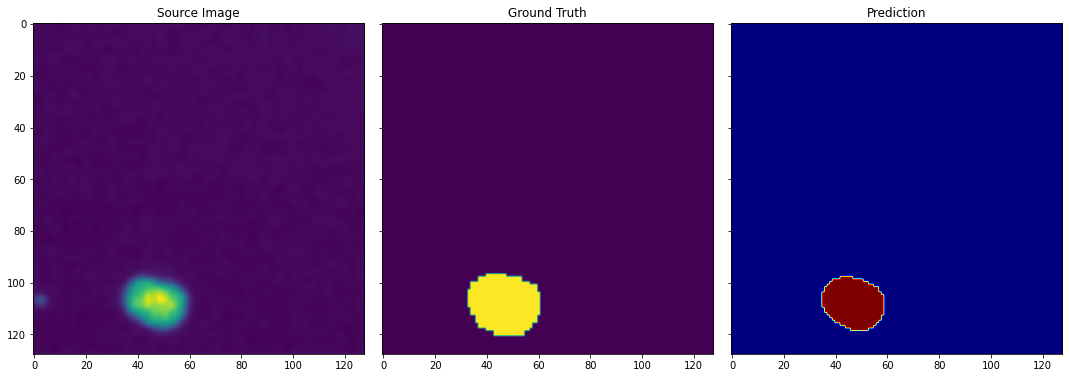

In [101]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(y_test[index, ..., 0])
ax[1].set_title('Ground Truth')

ax[2].imshow(y_pred[index, ..., 0], cmap='jet')
ax[2].set_title('Prediction')

fig.tight_layout()
plt.show()

In [108]:
from deepcell.metrics import Metrics
from skimage.morphology import remove_small_objects

y_true = y_test

benchmarks = Metrics(model_name, seg=False)
benchmarks.calc_object_stats(y_true, y_pred)
# Save benchmarks in dict
model_benchmarks = {}
for key in benchmarks.stats.keys():
    model_benchmarks[key] = int(benchmarks.stats[key].sum())

for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)

benchmarks = Metrics(model_name + ' - Removed objects less than {} pixels'.format(100), 
                        seg=False)
benchmarks.calc_object_stats(y_true, y_pred)

# Save benchmarks in dict
benchmarks_remove_small_objects = {}
for key in benchmarks.stats.keys():
    benchmarks_remove_small_objects[key] = int(benchmarks.stats[key].sum())

W0428 01:12:27.300724 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.313655 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.327067 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.340248 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.353775 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.366435 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.379934 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:27.392449 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:12:31.140955 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.153784 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.166603 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.179468 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.192257 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.205521 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.218715 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:31.231784 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:12:39.203932 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.217078 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.229685 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.242375 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.255285 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.267589 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.279939 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:39.292188 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:12:40.801416 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.813603 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.826476 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.838967 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.851837 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.864476 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.877307 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:40.890015 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:12:41.619648 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.632865 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.645867 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.658873 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.671692 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.683972 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.696421 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:12:41.709210 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:13:58.538001 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:13:58.550769 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:13:58.563470 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:13:58.587546 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:13:58.600726 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:13:58.614045 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:00.542884 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:00.555695 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:06.720724 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.733594 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.746732 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.759846 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.772956 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.786370 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.799777 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:06.813205 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:16.529770 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.543029 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.556441 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.570132 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.583683 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.596937 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.610150 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:16.623511 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:19.954933 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:19.979782 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:19.993736 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:20.007111 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:20.020519 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:20.035046 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:20.048757 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:20.062404 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:23.730134 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.743569 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.757534 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.771437 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.785130 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.799151 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.813088 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:23.826704 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti


____________Object-based statistics____________

Number of true cells:		 39608
Number of predicted cells:	 43728

Correct detections:  35064	Recall: 88.527570187840836979376035742461681365966796875%
Incorrect detections: 8664	Precision: 80.1866081229418199427527724765241146087646484375%

Gained detections: 8014	Perc Error: 66.2916701133261625500381342135369777679443359375%
Missed detections: 3535	Perc Error: 29.241459177764909327379427850246429443359375%
Merges: 443		Perc Error: 3.6644883778641741400861064903438091278076171875%
Splits: 91		Perc Error: 0.7527504342790967140075508723384700715541839599609375%
Catastrophes: 6		Perc Error: 0.04963189676565472885361174348872737027704715728759765625%

Gained detections from splits: 103
Missed detections from merges: 463
True detections involved in catastrophes: 12
Predicted detections involved in catastrophes: 13 

Average Pixel IOU (Jaccard Index): 0.72556493693068535577594957430846989154815673828125 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  from ipykernel import kernelapp as app
W0428 01:14:43.650496 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:43.663410 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:43.676624 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:43.689743 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:43.703021 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction 

W0428 01:14:47.278705 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.291474 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.304261 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.316889 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.329535 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.342192 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.355029 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:47.367767 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:54.339509 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:54.352854 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:54.366893 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:54.380085 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:55.083479 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:55.096745 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:55.109460 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:55.121681 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:56.769009 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.781619 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.794271 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.807242 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.820312 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.833404 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.846607 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:56.859862 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:14:57.608778 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.621327 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.634409 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.647106 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.659728 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.672522 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.685198 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:14:57.697651 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:15:02.852099 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.865128 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.878283 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.891350 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.904571 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.917877 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.931092 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:15:02.944369 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:16:14.285740 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.298707 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.311505 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.324162 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.337184 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.350167 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.363181 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:14.376152 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:16:22.916346 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:22.929109 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:22.941821 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:22.954507 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:22.974493 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:22.988602 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:23.002748 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:23.021776 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:16:26.091493 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.104747 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.117903 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.130880 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.147061 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.163811 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.177557 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:26.191399 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:16:29.996515 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.009208 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.021828 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.034379 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.049979 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.066271 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.079041 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:30.091979 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti

W0428 01:16:31.871746 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:31.889613 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:31.903700 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:33.503674 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:33.517227 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:33.530548 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:33.543360 140520475158336 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0428 01:16:33.556132 140520475158336 metrics.py:103] DICE score is technically 1.0, but predicti


____________Object-based statistics____________

Number of true cells:		 39608
Number of predicted cells:	 36850

Correct detections:  34338	Recall: 86.6946071500706949564118986018002033233642578125%
Incorrect detections: 2512	Precision: 93.1831750339213016331996186636388301849365234375%

Gained detections: 1996	Perc Error: 29.36157693439246685329635511152446269989013671875%
Missed detections: 4321	Perc Error: 63.562812591938808282066020183265209197998046875%
Merges: 446		Perc Error: 6.5607531626949100456158703309483826160430908203125%
Splits: 33		Perc Error: 0.4854368932038835016129496580106206238269805908203125%
Catastrophes: 2		Perc Error: 0.0294204177699323339567616386602821876294910907745361328125%

Gained detections from splits: 33
Missed detections from merges: 466
True detections involved in catastrophes: 4
Predicted detections involved in catastrophes: 4 

Average Pixel IOU (Jaccard Index): 0.72143750889611191201566953168367035686969757080078125 



In [109]:
model_name

'/data/models/04262020/nuclear_0_1_mobilenetv2_pixelwise/nuclear_0_1_mobilenetv2_pixelwise.h5'